In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as sio
import numpy as np
import time 
import matplotlib.pyplot as plt
import os

import models

### setting model parameters

In [3]:
model_layers   = 2
nonlinearity   = 'tanh'
latent_nums    = [1,2,3,4]
learning_rates = [1e-5,1e-5,1e-5,1e-5]
all_epochs     = [100000,100000,100000,100000]
 
test_skip_idx = 10   #grab every 10th entry of dictionary for testing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [4]:
#Loading the baseline dictionary
dictionary = sio.loadmat('../data/cone_12/basis.mat')['dMs']
print(dictionary.shape)

(144, 11757)


In [7]:
#split training and testing
dictionary_training = np.delete(dictionary,slice(None,None,test_skip_idx),axis=1)
dictionary_testing  = dictionary[:,::test_skip_idx]
    
[T,Ntraining] = dictionary_training.shape
[_,Ntesting]  = dictionary_testing.shape

In [8]:
print(T, Ntraining, Ntesting)

144 10581 1176


### training models

In [11]:
criterion = nn.MSELoss()

#re-shaping dictionary, casting it to right type, and sending it to GPU
dictionary_for_training = torch.tensor(np.transpose(dictionary_training,(1,0)),dtype = torch.float).to(device)

all_models = []

for latent_num,epochs,learning_rate in zip(latent_nums,all_epochs,learning_rates):
    starting_time = time.time()

    print('Latent Variables: %d || epochs: %d || learning rate: %.3f' % (latent_num,epochs,learning_rate))

    model = models.autoencoder(T,latent_num,model_layers,nonlinearity)
    model.to(device)

    optimizer = optim.Adam(model.parameters(),lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()

        output = model(dictionary_for_training)
        loss   = criterion(output,dictionary_for_training)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()

        if(epoch % 1000 == 0):
            print('  iteration %d/%d current loss: %.12f' % (epoch,epochs,running_loss))

    print('  final loss: %.12f' % running_loss)
    ending_time = time.time()
    print('  elapsed time: %.2f min' % ((ending_time - starting_time)/60))
    
    torch.save(model.state_dict(), os.path.join('checkpoints', f"{T}_{latent_num}_{model_layers}_{nonlinearity}"))

    all_models.append(model)
    

Latent Variables: 1 || epochs: 100000 || learning rate: 0.000
  iteration 0/100000 current loss: 0.088039033115
  iteration 1000/100000 current loss: 0.018108600751
  iteration 2000/100000 current loss: 0.003632731736
  iteration 3000/100000 current loss: 0.000674861192
  iteration 4000/100000 current loss: 0.000208388446
  iteration 5000/100000 current loss: 0.000167485196
  iteration 6000/100000 current loss: 0.000156519061
  iteration 7000/100000 current loss: 0.000142660982
  iteration 8000/100000 current loss: 0.000125550039
  iteration 9000/100000 current loss: 0.000106616702
  iteration 10000/100000 current loss: 0.000088025947
  iteration 11000/100000 current loss: 0.000071772709
  iteration 12000/100000 current loss: 0.000059458951
  iteration 13000/100000 current loss: 0.000051746185
  iteration 14000/100000 current loss: 0.000047578935
  iteration 15000/100000 current loss: 0.000045457495
  iteration 16000/100000 current loss: 0.000044367232
  iteration 17000/100000 current 

  iteration 49000/100000 current loss: 0.000001156513
  iteration 50000/100000 current loss: 0.000001117019
  iteration 51000/100000 current loss: 0.000001078966
  iteration 52000/100000 current loss: 0.000001043281
  iteration 53000/100000 current loss: 0.000001010563
  iteration 54000/100000 current loss: 0.000000981186
  iteration 55000/100000 current loss: 0.000000955154
  iteration 56000/100000 current loss: 0.000000932336
  iteration 57000/100000 current loss: 0.000000912365
  iteration 58000/100000 current loss: 0.000000894817
  iteration 59000/100000 current loss: 0.000000879172
  iteration 60000/100000 current loss: 0.000000865228
  iteration 61000/100000 current loss: 0.000000852685
  iteration 62000/100000 current loss: 0.000000841308
  iteration 63000/100000 current loss: 0.000000830999
  iteration 64000/100000 current loss: 0.000000821416
  iteration 65000/100000 current loss: 0.000000812655
  iteration 66000/100000 current loss: 0.000000804599
  iteration 67000/100000 cur

  iteration 99000/100000 current loss: 0.000000504260
  final loss: 0.000000499105
  elapsed time: 1.76 min
Latent Variables: 4 || epochs: 100000 || learning rate: 0.000
  iteration 0/100000 current loss: 0.032312370837
  iteration 1000/100000 current loss: 0.005569274072
  iteration 2000/100000 current loss: 0.000657038763
  iteration 3000/100000 current loss: 0.000184446297
  iteration 4000/100000 current loss: 0.000159747302
  iteration 5000/100000 current loss: 0.000145059574
  iteration 6000/100000 current loss: 0.000126470826
  iteration 7000/100000 current loss: 0.000103382867
  iteration 8000/100000 current loss: 0.000075825825
  iteration 9000/100000 current loss: 0.000047175639
  iteration 10000/100000 current loss: 0.000025909139
  iteration 11000/100000 current loss: 0.000015153049
  iteration 12000/100000 current loss: 0.000010454781
  iteration 13000/100000 current loss: 0.000008452395
  iteration 14000/100000 current loss: 0.000007456033
  iteration 15000/100000 current 

### computing training and testing errors

In [10]:
rmse = lambda truth, comp: np.sqrt(np.sum((comp - truth)**2,keepdims=False,axis=0)) / np.sqrt(np.sum(truth**2,keepdims=False,axis=0))

[u,s,v] = np.linalg.svd(dictionary,full_matrices=False)

all_basis = []

linear_errors_training   = []
proposed_errors_training = []

linear_errors_testing   = []
proposed_errors_testing = []

for latent_num, model in zip(latent_nums,all_models):
    #determine basis
    basis = u[:,0:latent_num]

    #estimate dictionaries with svd and autoencoder
    dictionary_estimate_linear_training   = basis @ np.conj(basis.T) @ dictionary_training
    dictionary_estimate_proposed_training = model(dictionary_for_training).cpu().detach().numpy().transpose((1,0))

    dictionary_estimate_linear_testing    = basis @ np.conj(basis.T) @ dictionary_testing
    dictionary_for_testing                = \
        torch.tensor(np.transpose(dictionary_testing,(1,0)),dtype = torch.float).to(device)
    dictionary_estimate_proposed_testing = \
        model(dictionary_for_testing).cpu().detach().numpy().transpose((1,0))

    error_linear_training   = rmse(dictionary_training,dictionary_estimate_linear_training)
    error_proposed_training = rmse(dictionary_training,dictionary_estimate_proposed_training)

    error_linear_testing    = rmse(dictionary_testing,dictionary_estimate_linear_testing)
    error_proposed_testing  = rmse(dictionary_testing,dictionary_estimate_proposed_testing)

    linear_errors_training.append(error_linear_training)
    proposed_errors_training.append(error_proposed_training)

    linear_errors_testing.append(error_linear_testing)
    proposed_errors_testing.append(error_proposed_testing)


### plotting entry by entry training error

average percent errors:
  proposed: 4.43
  linear:   31.88


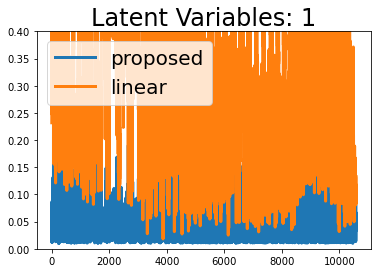

average percent errors:
  proposed: 1.97
  linear:   13.05


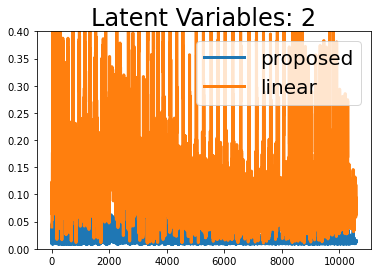

average percent errors:
  proposed: 1.91
  linear:   6.15


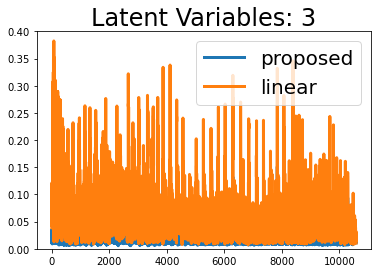

average percent errors:
  proposed: 1.54
  linear:   3.24


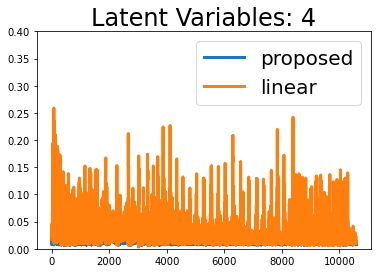

In [11]:
lw = 3
for latent_num,error_linear,error_proposed in zip(latent_nums,linear_errors_training,proposed_errors_training):
    print('average percent errors:')
    print('  proposed: %.2f' % (np.mean(error_proposed)*100))
    print('  linear:   %.2f' % (np.mean(error_linear)*100))
    
    plt.title('Latent Variables: %d' % latent_num,fontsize=24)
    plt.plot(error_proposed,linewidth=lw)
    plt.plot(error_linear,linewidth=lw)
    plt.legend(['proposed','linear'],prop={'size':20})
    plt.ylim([0,.4])
    plt.show()

### plotting entry by entry testing error

average percent errors:
  proposed: 4.49
  linear:   31.77


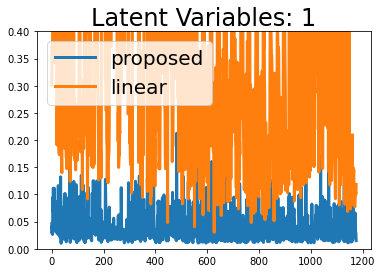

average percent errors:
  proposed: 1.99
  linear:   13.07


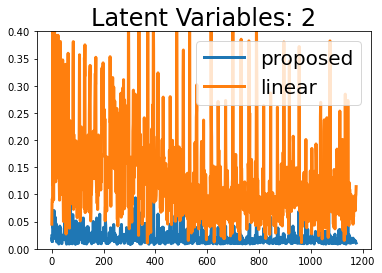

average percent errors:
  proposed: 1.94
  linear:   6.17


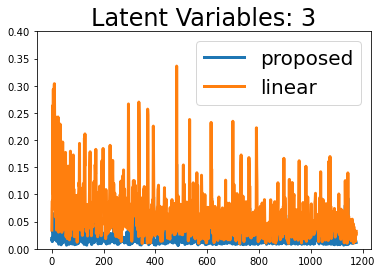

average percent errors:
  proposed: 1.55
  linear:   3.28


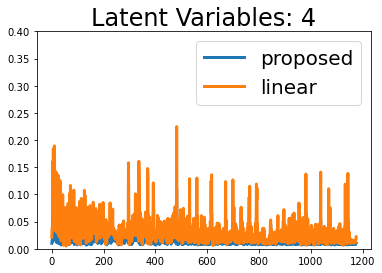

In [12]:
lw = 3
for latent_num,error_linear,error_proposed in zip(latent_nums,linear_errors_testing,proposed_errors_testing):
    print('average percent errors:')
    print('  proposed: %.2f' % (np.mean(error_proposed)*100))
    print('  linear:   %.2f' % (np.mean(error_linear)*100))\
    
    plt.title('Latent Variables: %d' % latent_num,fontsize=24)
    plt.plot(error_proposed,linewidth = lw)
    plt.plot(error_linear,  linewidth = lw)
    plt.legend(['proposed','linear'],prop={'size':20})
    plt.ylim([0,.4])
    plt.show()